In [1]:
from matplotlib import rcParams, rc
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import utils
from utils import Params
from tqdm import tqdm
from GLOnet_thinfilm import GLOnet
import scipy.io as io
from material_database import MatDatabase
from datetime import datetime
import h5py

tensor(802.7568)
tensor(1207.5189)


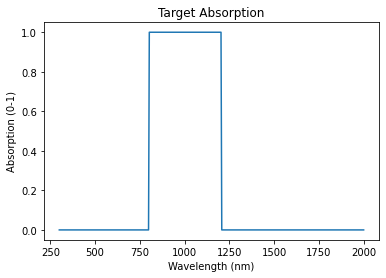

In [2]:
params = Params()
#Simulation Parameters

params.N_layers = 10 #Defines how many layers our thin film will be composed of
params.pol = 'p' # type str: 'p' or 's' (Set to 'p' by default)
params.k=  2*math.pi /torch.linspace(0.3,2, 400)  # Wavenumber
params.theta= torch.tensor([53*(math.pi/180)])  #Incident angle of light
params.materials = ['GGG','BK7'] #Incident and Exit Material

params.mobility= 14*10**-4 # m^2/(V x s)

#Layer Thickness
params.thickness_int=1/1000 # Microns
params.thickness_fin=11/1000
params.thickness_step=1/1000 

#Drude Model Parameters 
params.carrier_int=5 #Carrier Density in units of 10**20 (cm^-3)
params.carrier_fin=21
params.carrier_step=1

params.matdatabase = MatDatabase(params.materials)
params.n_database = params.matdatabase.interp_wv_complex(2 * math.pi/params.k, params.materials)
params.M_materials = len(params.n_database)
params.M_materials=torch.tensor(params.M_materials)
params.target_absorption = torch.zeros(params.k.size(0))


#Target Absorption Range
params.b1=118 #118
params.b2=213 #213
params.target_absorption[params.b1:params.b2] = 1
params.alpha_sup = 4

params.net = 'Res_Fixed' #Describes the Neural Network
params.res_layers = 12
params.res_dim = 1024 #64
params.noise_dim = 512 #16
params.s=1

params.lr = 0.02
params.beta1 = 0.9
params.beta2 = 0.99
params.weight_decay = 0.01
params.step_size = 25
params.gamma = 0.01


params.numIter =100
params.batch_size = 10
params.sigma =0.2 #0.2 
num_of_devices=1000

wavelength=(2*math.pi)/params.k
w=params.target_absorption[:].detach()
target=w.numpy()
plt.plot(wavelength*1000,target)
plt.ylabel("Absorption (0-1)")
plt.xlabel("Wavelength (nm)")
plt.title('Target Absorption')
print(str(wavelength[params.b1]*1000))
print(str(wavelength[params.b2]*1000))

100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


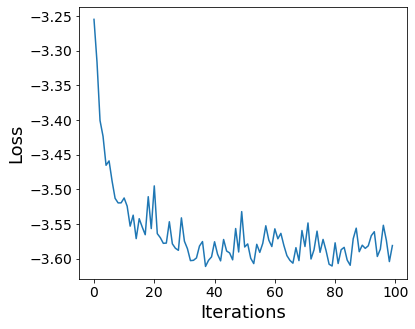

In [3]:
glonet = GLOnet(params)
glonet.train_fixed()
glonet.viz_training()
glonet.generator.eval()
thicknesses, drude_indices,transmission, reflection,carrier= glonet.evaluate_fixed(num_of_devices)

In [ ]:
with h5py.File('Example Thin Films.h5','w') as hf:
    hf.create_dataset('thicknesses',data=thicknesses)
    hf.create_dataset('drude_indices',data=drude_indices)
    hf.create_dataset('carrier', data=carrier)
    hf.create_dataset('transmission', data=transmission)
    hf.create_dataset('reflection', data=reflection)
    hf.create_dataset('target',data=target)
    hf.create_dataset('wavelength',data=wavelength)

In [4]:
with h5py.File('Thin Film Stack Simulations/Broadband Absorbers NN Designed/Layers_10.h5','r') as hf:
    thicknesses=hf['thicknesses'][...]
    drude_indices=hf['drude_indices'][...]
    carrier=hf['carrier'][...]
    transmission=hf['transmission'][...]
    reflection=hf['reflection'][...]
    target=hf['target'][...]

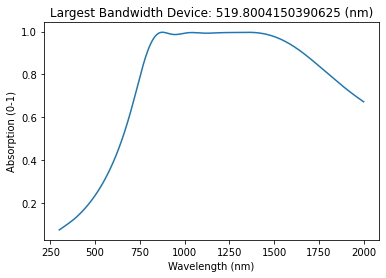

<Figure size 432x288 with 0 Axes>

In [7]:
def Bandwidth_Plot(wavelength,transmission,reflection,threshold=0.99):
    absorption=1-transmission-reflection
    delta_wavelength=wavelength[1]-wavelength[0]
    if absorption.shape[1]!=1:
        absorption=absorption[:,np.newaxis,:]

    Bandwidth_List=np.zeros(absorption.shape[0])
    for idx in range(absorption.shape[0]):
        value=0
        for i in range(absorption.shape[-1]):
            if (absorption[idx,0,i])>=threshold:
                value+=1
        Bandwidth_List[idx]=value*1000*(delta_wavelength)
    
    for indx in range(Bandwidth_List.shape[0]):
        if Bandwidth_List[indx]==max(Bandwidth_List):
            plt.plot(wavelength*1000,absorption[indx,0,:])
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Absorption (0-1)')
            plt.title('Largest Bandwidth Device: '+str(max(Bandwidth_List))+" (nm)")
            plt.figure()

    
Bandwidth_Plot(wavelength,transmission,reflection)